In [ ]:
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-oa01g2jx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-oa01g2jx
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=acb60f0f68865d06f22acf978ca1d694e4e91d010459057339ae83d11c8bfa10
  Stored in directory: /tmp/pip-ephem-wheel-cache-x0hdvg8c/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from torch.utils.data import Dataset
import pandas as pd
from PIL import Image
import time
import sys
import numpy as np
import cv2
import textwrap
from multiprocessing import Pool
import clip
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
main_dir = "/content/drive/MyDrive/personal/deep_learning_final"
os.chdir(main_dir)

In [ ]:
df = pd.read_parquet("./image_captions_embeddings_all.parquet", engine="pyarrow")

In [ ]:
df.head()

,image_id,image_path,caption,features
0,127721,./coco_train2014/train2014/COCO_train2014_0000...,Man on a skateboard in the air doing a trick.,"[0.10272217, 0.10089111, -0.13964844, -0.30151..."
1,263275,./coco_train2014/train2014/COCO_train2014_0000...,a male snowboarder in a white shirt is doing a...,"[0.05630493, 0.025543213, 0.15515137, 0.077697..."
2,428761,./coco_train2014/train2014/COCO_train2014_0000...,LOTS OF BIRDS SITTING ON THE WIRES ON CHERRY A...,"[0.18395996, 0.18774414, -0.10479736, -0.51855..."
3,102066,./coco_train2014/train2014/COCO_train2014_0000...,To go vases sitting next to each other along w...,"[0.06756592, 0.053985596, -0.2998047, -0.08923..."
4,348948,./coco_train2014/train2014/COCO_train2014_0000...,A plate sitting on top of a table topped with ...,"[-0.27807617, 0.09680176, 0.13195801, 0.042968..."


In [ ]:
# Create multiple datasets because each image has multiple captions
# Each dataset samples a random caption for each image
# could not just keep the original dataset because using multiple workers
# for training, multiple workers can read the same image at the same time
# causing issues

datasets = []
for i in range(5):
  d = df.groupby('image_id')[['image_path', 'caption', 'features']]\
   .apply(lambda x: x.sample(1))\
    .reset_index().drop('level_1', axis = 1).copy()
  datasets.append(d)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# class for dataloader to be able to utilize faster processing and training
class ImageCaptionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.caption_embeddings = [torch.tensor(x).unsqueeze(0) for x in df['features']]
        self.image_paths = df['image_path'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['image_path']
        caption = row['caption']
        caption_embedding = self.caption_embeddings[idx]
        with Image.open(image_path) as img:
          img = img.convert('RGB')
        if self.transform:
            img = self.transform(img)

        return img, caption_embedding, caption


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #torch.device("cpu") #

In [ ]:
# image encoder: 3x224x224 -> 1x512
class ImageEncoder(nn.Module):
  def __init__(self, image_size = 224, channels = 3):
    super(ImageEncoder, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(channels, 64, kernel_size=3, stride=2, padding=1),  # 64x112x112
        nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # 128x56x56
        nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # 256x28x28
        nn.BatchNorm2d(256),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),  # 512x14x14
        nn.BatchNorm2d(512),
        nn.LeakyReLU(negative_slope=0.1),
        nn.Flatten(),
        nn.Linear(512*14*14, 512)  # Output: 512 features
        )
  def forward(self, x):
    return self.encoder(x)

In [ ]:
# main encoder: image embedding + caption embedding -> mean, logvar
# 1x512 + 1x512 -> 1x128, 1x128
class Encoder(nn.Module):
    def __init__(self, image_embedding_dim=512, embedding_dim=512, latent_dim=128):
        super(Encoder, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(image_embedding_dim + embedding_dim, 512),  # Combine image and CLIP embeddings
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(512, 256),
            nn.LeakyReLU(negative_slope=0.1)
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)
    def forward(self, image_embedding, clip_embedding):
        x = torch.cat((image_embedding, clip_embedding), dim=1) # concatenation
        x = self.fc(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar


In [ ]:
# Decoder: latent + caption embedding -> 3x224x224 image
#
class Decoder(nn.Module):
  def __init__(self, latent_dim=128, embedding_dim=512, output_channels=3):
    super(Decoder, self).__init__()
    self.fc = nn.Sequential(
        nn.Linear(latent_dim + embedding_dim, 512 * 7 * 7),  # map to feature map size
        nn.LeakyReLU(negative_slope=0.1)
        )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 256x14x14
        nn.BatchNorm2d(256),
        nn.LeakyReLU(negative_slope=0.1),
        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 128x28x28
        nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.1),
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 64x56x56
        nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope=0.1),
        nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 3x112x112
        nn.BatchNorm2d(32),
        nn.LeakyReLU(negative_slope=0.1),
        nn.ConvTranspose2d(32, output_channels, kernel_size=4, stride=2, padding=1),
        nn.Sigmoid()
        )
  def forward(self, z, c):
    z_cond = torch.cat((z, c), dim=1) # concatenation
    x = self.fc(z_cond)
    x = x.view(-1, 512, 7, 7)  # reshape to match feature map dimensions
    reconstructed = self.decoder(x)
    return reconstructed

In [ ]:
# full cVAE: image + caption -> better image, mean, logvar
class CVAE(nn.Module):
  def __init__(self, image_size=224, latent_dim=128, embedding_dim=512, hidden_size=256):
    super(CVAE, self).__init__()
    self.image_encoder = ImageEncoder(image_size)
    self.encoder = Encoder(512, embedding_dim, latent_dim)
    self.decoder = Decoder(latent_dim, embedding_dim, output_channels=3)
  def reparameterize(self, mean, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mean + eps * std
  def forward(self, x, c):
    x = self.image_encoder(x)
    mean, logvar = self.encoder(x, c)
    z = self.reparameterize(mean, logvar)
    x_reconstructed = self.decoder(z, c)
    return x_reconstructed, mean, logvar

In [ ]:
def loss_function(x_reconstructed, x, mean, logvar):
  # Reconstruction Loss
  recon_loss = F.binary_cross_entropy(x_reconstructed, x, reduction='sum')
  # KL Divergence Loss
  kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
  return recon_loss + kl_loss

In [ ]:
model = CVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [ ]:
# load last saved model state dict
checkpoint = torch.load('./coco_cvae.pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
epochs = 25
left_off = 100

In [ ]:
# iterate over each dataset and train amount of epochs for each
for i in range(len(datasets)):
  # create dataloader for specific dataset
  dataset = ImageCaptionDataset(datasets[i], transform=transform)
  batch_size = 64
  dataloader = torch.utils.data.DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
      num_workers=10,
      prefetch_factor=2,
      persistent_workers=True
      )

  l = len(dataloader)
  for epoch in range(epochs):
    model.train()
    train_loss = 0
    for idx, (img, embedding, c) in enumerate(dataloader):
      sys.stdout.write(f"\rProgress: {idx}/{l}")
      sys.stdout.flush()
      # Forward pass
      embedding = embedding.squeeze(1)
      img = img.to(device)
      embedding = embedding.to(device)
      x_reconstructed, mean, logvar = model(img, embedding)
      # Compute loss
      loss = loss_function(x_reconstructed, img, mean, logvar)
      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
      optimizer.step()

      train_loss += loss.item()

    avg_loss = train_loss / len(dataloader)
    print(f" Dataset {i+1}, Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    if (epoch+1) % 25 == 0:
      torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
          }, f"cvae_checkpoint_epoch_{epoch+left_off}.pth")

  left_off += epochs
  torch.save({
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict()
  },  './coco_cvae.pth')

Progress: 1293/1294 Dataset 1, Epoch 1/10, Loss: 5372017.8373
Progress: 1293/1294 Dataset 1, Epoch 2/10, Loss: 5363299.7208
Progress: 1293/1294 Dataset 1, Epoch 3/10, Loss: 5358385.4115
Progress: 1293/1294 Dataset 1, Epoch 4/10, Loss: 5354755.8528
Progress: 1293/1294 Dataset 1, Epoch 5/10, Loss: 5351422.1267
Progress: 1293/1294 Dataset 1, Epoch 6/10, Loss: 5348858.5035
Progress: 1293/1294 Dataset 1, Epoch 7/10, Loss: 5346411.5102
Progress: 1293/1294 Dataset 1, Epoch 8/10, Loss: 5344485.9349
Progress: 1293/1294 Dataset 1, Epoch 9/10, Loss: 5342336.7740
Progress: 1293/1294 Dataset 1, Epoch 10/10, Loss: 5340422.5460
Progress: 1293/1294 Dataset 2, Epoch 1/10, Loss: 5353886.5321
Progress: 1293/1294 Dataset 2, Epoch 2/10, Loss: 5347085.0842
Progress: 1293/1294 Dataset 2, Epoch 3/10, Loss: 5343314.6662
Progress: 1293/1294 Dataset 2, Epoch 4/10, Loss: 5340630.8056
Progress: 1293/1294 Dataset 2, Epoch 5/10, Loss: 5338485.2985
Progress: 1293/1294 Dataset 2, Epoch 6/10, Loss: 5336631.8843
Progres

In [ ]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 152MiB/s]


In [ ]:
def generate_images(model, captions, device):
  num_samples = len(captions)
  model.eval()
  text_inputs = clip.tokenize(captions).to(device)
  with torch.no_grad():
    text_embeddings = clip_model.encode_text(text_inputs)

  z = torch.randn(num_samples, 128)
  z = z.to(device)
  text_embeddings = text_embeddings.to(device)
  with torch.no_grad():
      generated_images = model.decoder(z, text_embeddings)
  return generated_images

In [ ]:
test_captions = [
    'a futuristic cityscape with flying cars and neon-lit buildings',
    'a serene beach with clear water and swaying palm trees',
    'a majestic tiger walking through a sunlit jungle',
    'a cozy cabin in a snowy forest with glowing lights',
    'a robot chef cooking a colorful gourmet dish in a high-tech kitchen'
]

In [ ]:
gen_images = generate_images(model, test_captions, device)

In [ ]:
gen_images.shape

torch.Size([5, 3, 224, 224])

In [ ]:
def plot_images(image_batch, captions):
    num_images = image_batch.size(0)
    if num_images > 5:
      raise ValueError("Can only plot up to 5 images at a time")
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
      image = image_batch[i]
      caption = captions[i]
      wrapped_caption = "\n".join(textwrap.wrap(caption, width=30))
      image = image.permute(1, 2, 0).cpu().numpy()
      ax = axes[i] if num_images > 1 else axes
      ax.imshow(image)
      ax.set_title(wrapped_caption, fontsize=10)
      ax.axis("off")

    plt.tight_layout()
    plt.show()

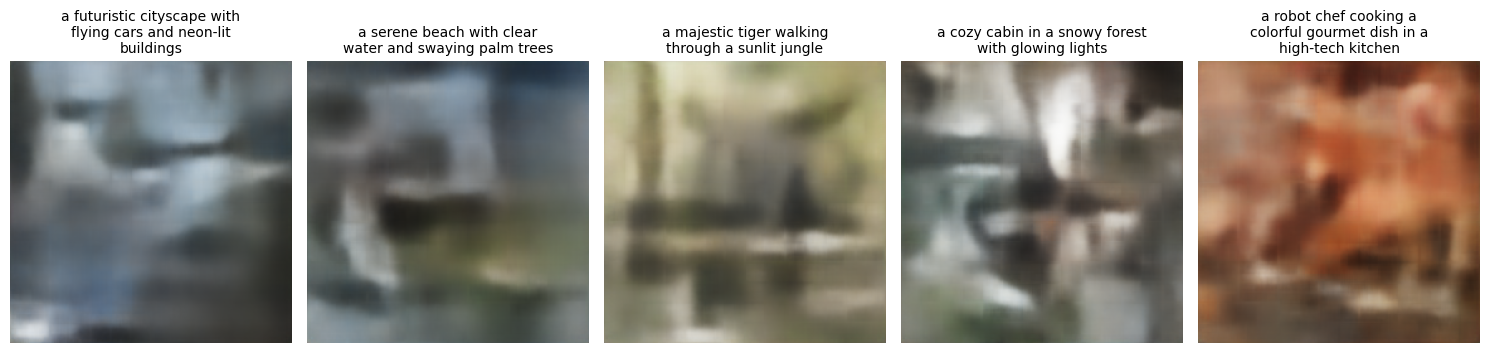

In [ ]:
plot_images(gen_images, test_captions)